# BE - Visualizing and validating data

Dwayne Herzberg

---


# Settings and imports

In [1]:
import pandas as pd
import zipfile
from io import StringIO
import pathlib

In [2]:
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

FILE_NAME = "BrtPdm_CHIMIE_20230221.zip"

COLUMNS_TIME = [
    "20t_Date",
    "20t_DateZero",
    "20t_DateMaz"
]

TIME_FORMAT = "%d/%m/%Y,%H:%M:%S"

COLUMN_TYPES = {
    "5d_CO": int,
    "5d_COvrai": int,
    "8s_flag": "string",
    "6.4f_ratio": float,
    "6.0f_agci": float,
    "5.1f_intT": float,
    "5.2f_flow": float,
    "5d_bkg": int,
    "5.2f_coef": float,
    "6.1f_biasvoltage": float,
    "5d_moy": int,
    "5.1f_ect": float,
    "5d_vMin": int,
    "5d_vMax": int,
    "5d_oldBkg": int,
    "5d_newBkg": int,
    "4d_Ozone": int,
    "4d_Pression": int,
    "4.2f_flowA": float,
    "4.2f_flowB": float,
    "3.1f_bkg": float,
    "5.1f_benchT": float,
    "5.1f_O3lampT": float,
    "5.1f_lampSetting": float,
    "6d_cellAInt": int,
    "6d_cellBInt": int,
}

# can be useful
COLUMNS_DESCRIPTIVE = {
    "5d_CO": "",
    "5d_COvrai": "",
    "6.4f_ratio": "",
    "6.0f_agci": "",
    "5.1f_intT": "",
    "5.2f_flow": "",
    "5d_bkg": "",
    "5.2f_coef": "",
    "6.1f_biasvoltage": "",
    "5d_moy": "",
    "5.1f_ect": "",
    "5d_vMin": "",
    "5d_vMax": "",
    "5d_oldBkg": "",
    "5d_newBkg": "",
    # TEI49 - Ozone
    "8s_flag": "status code",
    "4d_Ozone": "ozone concentration",
    "4d_Pression": "pressure measurements",
    "4.2f_flowA": "flow rates channel A",
    "4.2f_flowB": "flow rates channel B",
    "3.1f_bkg": "background signal",
    "5.1f_benchT": "instrument's bench temperature",
    "5.1f_O3lampT": "ozone lamp temperature",
    "5.1f_lampSetting": "ozone lamp setting",
    "6d_cellAInt": "cell A intensity",
    "6d_cellBInt": "cell B intensity",
}

# Loading the data


In [3]:
def read_zip_file(zip_file_path: str) -> dict[str, pd.DataFrame]:
    """
    Read the contents of a zip file and return a dictionary of DataFrames.

    Parameters
    ----------
    zip_file_path : str
        The path to the zip file.

    Returns
    -------
    dict[str, pd.DataFrame]
        A dictionary of DataFrames with the file name as the key.
    """
    dfs: dict[str, pd.DataFrame] = {}

    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.endswith(".txt"):
                with zip_ref.open(file_name) as file:
                    file_contents = file.read().decode("utf-8")
                try:
                    header, data = file_contents.strip().split("\n", 1)
                    header_list = header.split(sep=",")
                    df = pd.read_csv(StringIO(data), header=None,
                                     names=header_list, sep=" ")
                except ValueError:
                    header_list = file_contents.strip().split(sep=",")
                    df = pd.DataFrame(columns=header_list)
                file_name = file_name.replace(".txt", "")
                df.Name = file_name
                dfs[file_name] = df
    return dfs

In [4]:
dfs = read_zip_file(DATA_DIRECTORY / FILE_NAME)

---

# Configuring the data

In [5]:
def for_each_df(dfs: dict[str, pd.DataFrame], func: callable, **kwargs) -> None:
    """
    Apply a function to each DataFrame in a dictionary of DataFrames.

    Parameters
    ----------
    dfs : dict[str, pd.DataFrame]
        A dictionary of DataFrames.

    func : callable
        A function to apply to each DataFrame.

    **kwargs
        Keyword arguments to pass to the function.

    Raises
    ------
    TypeError
        If dfs is not a dictionary of DataFrames.
    TypeError
        If dfs keys are not strings.
    TypeError
        If dfs values are not DataFrames.
    TypeError
        If func is not a callable.
    """
    if not isinstance(dfs, dict):
        raise TypeError("dfs must be a dictionary of DataFrames")

    if not all(isinstance(key, str) for key in dfs.keys()):
        raise TypeError("dfs keys must be strings")

    if not all(isinstance(df, pd.DataFrame) for df in dfs.values()):
        raise TypeError("dfs values must be DataFrames")

    if not callable(func):
        raise TypeError("func must be a callable")

    for df in dfs.values():
        func(df, **kwargs)


def apply_time_df(df: pd.DataFrame, time_columns: list[str], time_format: str | None = None) -> None:
    """
    Convert columns in a DataFrame to datetime64.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame to convert the columns in.

    time_columns : list[str]
        A list of column names to convert to datetime64.

    time_format : str | None
        The format of the time columns. If None, the default format is used.
    """
    for col in time_columns:
        if col in df.columns:
            try:
                df[col] = pd.to_datetime(df[col], format=time_format)
            except ValueError as e:
                print(
                    f"Failed to convert column {col} to datetime64 on {df.Name}.")
                print(e)


def apply_time_dfs(dfs: dict[str, pd.DataFrame], time_columns: list[str], time_format: str | None = None) -> None:
    """
    Convert columns in a dictionary of DataFrames to datetime64.

    Parameters:
    -----------
    dfs : dict[str, pd.DataFrame]
        The dictionary of DataFrames to convert the columns in.

    time_columns : list[str]
        A list of column names to convert to datetime64.

    time_format : str | None
        The format of the time columns. If None, the default format is used.
    """
    for_each_df(dfs, apply_time_df, time_columns=time_columns,
                time_format=time_format)


def apply_types_df(df: pd.DataFrame, dtype_dict: dict[str, str]) -> None:
    """
    Apply specified data types to columns in a DataFrame.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame to apply the data types to.

    dtype_dict : dict[str, str]
        A dictionary of column names and data types.

    Returns:
    --------
    pd.DataFrame
        The DataFrame with the data types applied.
    """
    for column, dtype in dtype_dict.items():
        if column in df.columns:
            df[column] = df[column].astype(dtype)


def apply_types_dfs(dfs: dict[str, pd.DataFrame], dtype_dict: dict[str, str]) -> None:
    """
    Apply specified data types to columns in a dictionary of DataFrames.

    Parameters:
    -----------
    dfs : dict[str, pd.DataFrame]
        A dictionary of DataFrames.

    dtype_dict : dict[str, str]
        A dictionary of column names and data types.
    """
    for_each_df(dfs, apply_types_df, dtype_dict=dtype_dict)


def check_dtype_df(df: pd.DataFrame, dtype_dict: dict[str, str], time_columns: list[str]) -> None:
    """
    Check that the data types of a DataFrame are correct.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to check.

    dtype_dict : dict[str, str]
        A dictionary of column names and data types.

    time_columns : list[str]
        A list of columns that should be datetime objects.
    """
    for column, dtype in dtype_dict.items():
        if column not in df.columns:
            continue
        if df[column].dtype != dtype:
            print(
                f"Column {column} should be {dtype}, not '{df[column].dtype}' on {df.Name}")

    for column in time_columns:
        if column not in df.columns:
            continue
        if df[column].dtype != "datetime64[ns]":
            print(
                f"Column {column} should be datetime64[ns], not '{df[column].dtype}' on {df.Name}")


def check_dtype_dfs(dfs: dict[str, pd.DataFrame], dtype_dict: dict[str, str], time_columns: list[str]) -> None:
    """
    Check that the data types of a dictionary of DataFrames are correct.

    Parameters
    ----------
    dfs : dict[str, pd.DataFrame]
        A dictionary of DataFrames.

    dtype_dict : dict[str, str]
        A dictionary of column names and data types.

    time_columns : list[str]
        A list of columns that should be datetime objects.
    """
    for_each_df(dfs, check_dtype_df, dtype_dict=dtype_dict,
                time_columns=time_columns)

configuring the columns types:
  - `date` columns are converted to `datetime` objects (COLUMNS_TIME)
  - each column is converted to the appropriate type (COLUMN_TYPES)

In [6]:
apply_types_dfs(dfs, COLUMN_TYPES)
apply_time_dfs(dfs, COLUMNS_TIME, TIME_FORMAT)

for each column on each dataframe, check if all types are respected

In [7]:
check_dtype_dfs(dfs, COLUMN_TYPES, COLUMNS_TIME)

---

# Understanding the data

In [8]:
def get_df(dfs: dict[str, pd.DataFrame], name: str) -> pd.DataFrame:
    """
    Get a DataFrame from a dictionary of DataFrames.

    Parameters
    ----------
    dfs : dict[str, pd.DataFrame]
        A dictionary of DataFrames.

    name : str
        The name of the DataFrame to get.

    Returns
    -------
    pd.DataFrame
        The DataFrame with the specified name.
    """
    if name not in dfs.keys():
        raise KeyError(f"DataFrame {name} not found in dictionary")
    return dfs[name]


def print_shape_df(df: pd.DataFrame) -> None:
    """
    Print the number of rows and columns in a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to print the shape of.
    """
    print(f"{df.Name} has {df.shape[0]} rows and {df.shape[1]} columns")


def print_shape_dfs(dfs: dict[str, pd.DataFrame]) -> None:
    """
    Print the number of rows and columns in a dictionary of DataFrames.

    Parameters
    ----------
    dfs : dict[str, pd.DataFrame]
        A dictionary of DataFrames.
    """
    for_each_df(dfs, print_shape_df)


def print_df_names(dfs: dict[str, pd.DataFrame]) -> None:
    """
    Print the names of the DataFrames in a dictionary.

    Parameters
    ----------
    dfs : dict[str, pd.DataFrame]
        A dictionary of DataFrames.
    """
    for name in dfs.keys():
        print(name)


def get_df_names(dfs: dict[str, pd.DataFrame]) -> list[str]:
    """
    Get the names of the DataFrames in a dictionary.

    Parameters
    ----------
    dfs : dict[str, pd.DataFrame]
        A dictionary of DataFrames.

    Returns
    -------
    list[str]
        A list of the names of the DataFrames in the dictionary.
    """
    return list(dfs.keys())


def get_column_descriptions(column: str) -> str:
    """
    Get the description of a column from the COLUMNS_DESCRIPTIVE dictionary.

    Parameters
    ----------
    column : str
        The name of the column to get the description of.

    Returns
    -------
    str
        The description of the column.
    """
    if column in COLUMNS_DESCRIPTIVE.keys():
        return COLUMNS_DESCRIPTIVE[column]
    return ""


def analyse_time_column(df: pd.DataFrame, column: str) -> None:
    """
    Print information about a time column in a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to analyse.

    column : str
        The name of the column to analyse.
    """
    print(f"{df.Name} - {column}")
    print(f"First: {df[column].min()}")
    print(f"Last: {df[column].max()}")


def plot_df(df: pd.DataFrame, columns_ref: str) -> None:
    """
    Plot each column in a DataFrame on a separate plot.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to plot.

    columns_ref : str
        The name of the column to use as the reference for the x-axis.
    """
    df.plot(subplots=True, x=columns_ref, figsize=(15, 10))


## Global overview

files are grouped by instrument:
- Files named `TEI48` are linked to an instrument from **CO**.
- Files named `TEI49` are linked to an instrument from **Ozone**.

files are grouped by type:
- `Data` files are the **data**
- The `Fonct` files are the **operating parameters** of the instruments
- The `Zero` file is related to a **calibration** of the CO

In [9]:
print_df_names(dfs)

Pdm_TEI48_Data_20230221
Pdm_TEI48_Fonct_20230221
Pdm_TEI48_Zero_20230221
Pdm_TEI49_Data_20230221
Pdm_TEI49_Fonct_20230221


In [10]:
print_shape_dfs(dfs)

Pdm_TEI48_Data_20230221 has 0 rows and 3 columns
Pdm_TEI48_Fonct_20230221 has 0 rows and 9 columns
Pdm_TEI48_Zero_20230221 has 0 rows and 8 columns
Pdm_TEI49_Data_20230221 has 1728 rows and 3 columns
Pdm_TEI49_Fonct_20230221 has 288 rows and 12 columns


## TEI49 - Ozone

- both files
  - **20t_Date**: Date and time of each measurement. The "20t" indicates that the timestamp includes 20 characters.
- Data file
  - **4d_Ozone**: Ozone concentration measurements, in units of parts per billion (ppb). The "4d" indicates that the variable is represented with 4 decimal places of precision.
  - **4d_Pression**: Pressure measurements, in units of millibars (mb). The "4d" indicates that the variable is represented with 4 decimal places of precision.
- Fonct file
  - **8s_flag**: Flag or status code for each measurement. The "8s" indicates that the variable is represented with 8 characters.
  - **4.2f_flowA** and **4.2f_flowB**: Flow rates of the two channels in the instrument. The "4.2f" indicates that the variables are represented with 4 digits before the decimal point and 2 digits after the decimal point.
  - **3.1f_bkg**: Background signal in the instrument. The "3.1f" indicates that the variable is represented with 3 digits before the decimal point and 1 digit after the decimal point.
  - **5.2f_coef**: Calibration coefficient for the instrument. The "5.2f" indicates that the variable is represented with 5 digits before the decimal point and 2 digits after the decimal point.
  - **5.1f_benchT**, **5.1f_O3lampT**, **5.1f_intT**, and **5.1f_lampSetting**: temperature of the instrument's bench, the temperature of the ozone lamp, the internal temperature of the instrument, and the setting of the ozone lamp. The "5.1f" indicates that the variables are represented with 5 digits before the decimal point and 1 digit after the decimal point.
  - **6d_cellAInt** and **6d_cellBInt**: Intensities of the two channels in the instrument. The "6d" likely indicates that the variables are represented with 6 digits.

### Data file

In [11]:
TEI49_Data = get_df(dfs, "Pdm_TEI49_Data_20230221")
TEI49_Data.head()

,20t_Date,4d_Ozone,4d_Pression
0,2023-02-21 00:00:02,41,535
1,2023-02-21 00:00:32,40,533
2,2023-02-21 00:01:02,41,535
3,2023-02-21 00:03:32,41,532
4,2023-02-21 00:04:02,40,536


In [12]:
analyse_time_column(TEI49_Data, "20t_Date")

Pdm_TEI49_Data_20230221 - 20t_Date
First: 2023-02-21 00:00:02
Last: 2023-02-21 23:59:32


In [13]:
TEI49_Data.describe().loc[["min", "max", "mean"]]

,4d_Ozone,4d_Pression
min,36.000000,528.000000
max,54.000000,536.000000
mean,39.981481,531.722222


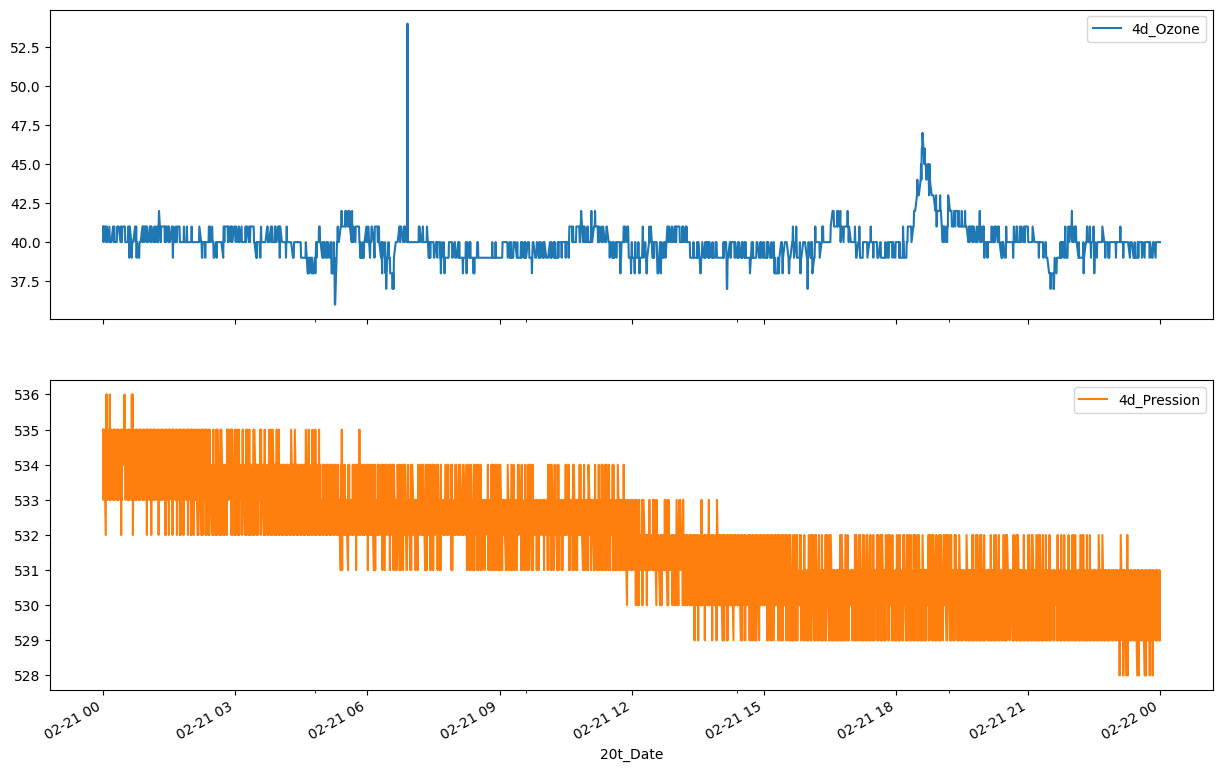

In [14]:
plot_df(TEI49_Data, "20t_Date")

### Fonct file

In [15]:
TEI49_Fonct = get_df(dfs, "Pdm_TEI49_Fonct_20230221")
TEI49_Fonct.head()

,20t_Date,8s_flag,4.2f_flowA,4.2f_flowB,3.1f_bkg,5.2f_coef,5.1f_benchT,5.1f_O3lampT,5.1f_intT,5.1f_lampSetting,6d_cellAInt,6d_cellBInt
0,2023-02-21 00:01:02,99999999,1.24,1.24,-99999.9,-99.9,28.8,0.0,53.6,-99.9,149887,144303
1,2023-02-21 00:06:02,99999999,1.13,1.09,-99999.9,-99.9,28.7,0.0,53.7,-99.9,149912,144320
2,2023-02-21 00:11:02,99999999,1.24,1.23,-99999.9,-99.9,28.7,0.0,53.5,-99.9,149872,144277
3,2023-02-21 00:16:02,99999999,1.15,1.10,-99999.9,-99.9,28.6,0.0,53.6,-99.9,149901,144297
4,2023-02-21 00:21:02,99999999,1.17,1.12,-99999.9,-99.9,28.6,0.0,53.6,-99.9,149858,144250


In [16]:
analyse_time_column(TEI49_Fonct, "20t_Date")

Pdm_TEI49_Fonct_20230221 - 20t_Date
First: 2023-02-21 00:01:02
Last: 2023-02-21 23:56:02


In [17]:
TEI49_Fonct.describe().loc[["min", "max", "mean"]]

,4.2f_flowA,4.2f_flowB,3.1f_bkg,5.2f_coef,5.1f_benchT,5.1f_O3lampT,5.1f_intT,5.1f_lampSetting,6d_cellAInt,6d_cellBInt
min,1.120000,1.080000,-99999.9,-99.9,27.400000,0.0,53.400000,-99.9,148935.000000,142248.000000
max,1.250000,1.240000,-99999.9,-99.9,30.800000,0.0,53.800000,-99.9,149912.000000,144320.000000
mean,1.207778,1.188229,-99999.9,-99.9,28.607986,0.0,53.608333,-99.9,149406.114583,143221.402778


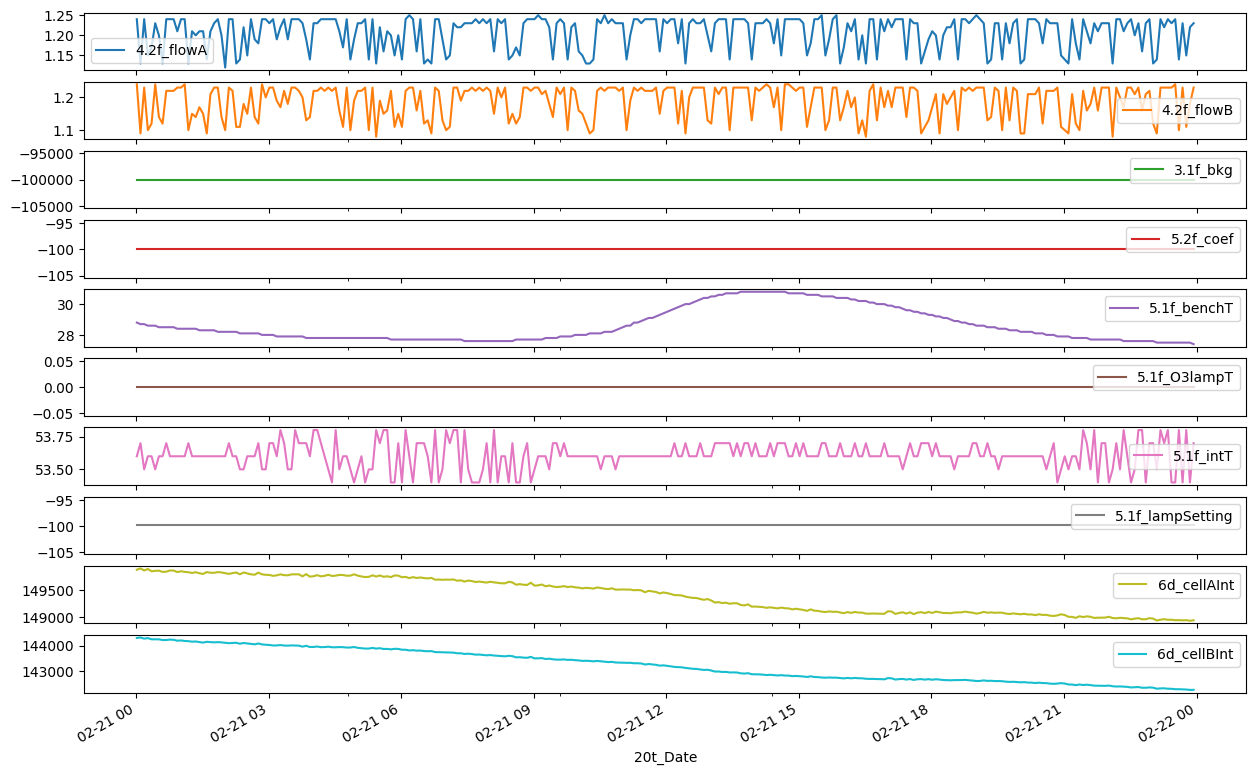

In [18]:
plot_df(TEI49_Fonct, "20t_Date")

---